In [1]:
import zipfile, os, shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory('cifake/train',
                                              target_size=(32, 32),
                                              batch_size=32,
                                              class_mode='categorical')

validation_generator = datagen.flow_from_directory('cifake/valid',
                                                   target_size=(32, 32),
                                                   batch_size=32,
                                                   class_mode='categorical')

Found 10000 images belonging to 2 classes.
Found 5002 images belonging to 2 classes.


In [4]:
def create_patches(inputs, patch_size):
    patches = tf.image.extract_patches(images=inputs,
                                       sizes=[1, patch_size, patch_size, 1],
                                       strides=[1, patch_size, patch_size, 1],
                                       rates=[1, 1, 1, 1],
                                       padding='VALID')
    patch_dim = patches.shape[-1]
    patches = tf.reshape(patches, [tf.shape(inputs)[0], -1, patch_dim])
    return patches

def patch_embedding(patches, embed_dim):
    projection = layers.Dense(embed_dim)
    embeddings = projection(patches)
    return embeddings

def add_classification_token(embeddings, embed_dim):
    batch_size = tf.shape(embeddings)[0]
    cls_token = tf.zeros((batch_size, 1, embed_dim))
    embeddings = tf.concat([cls_token, embeddings], axis=1)
    return embeddings 

def positional_embedding(sequence_length, embed_dim):
    positions = tf.range(sequence_length + 1)
    projection = layers.Embedding(sequence_length + 1, embed_dim)
    position = projection(positions)
    return position

def transformer_block(embed_dim, num_heads, sequence_length):
    inputs = keras.Input(shape=(sequence_length + 1, embed_dim))
    x1 = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x2 = layers.MultiHeadAttention(num_heads, embed_dim)(x1, x1)
    x3 = layers.LayerNormalization(epsilon=1e-6)(inputs + x2)
    x4 = layers.Dense(embed_dim, activation='gelu')(x3)
    x5 = layers.Dense(embed_dim)(x4)
    outputs = layers.LayerNormalization(epsilon=1e-6)(x3 + x5)
    return keras.Model(inputs=inputs, outputs=outputs)

def vision_transformer(image_size, patch_size, embed_dim, num_heads, sequence_length):
    inputs = keras.Input(shape=(image_size, image_size, 3))
    patches = create_patches(inputs, patch_size)
    embeddings = patch_embedding(patches, embed_dim)
    embeddings = add_classification_token(embeddings, embed_dim)
    embeddings += positional_embedding(sequence_length, embed_dim)
    for i in range(4):
        transformer = transformer_block(embed_dim, num_heads, sequence_length)
        embeddings = transformer(embeddings)
    cls_token = embeddings[:, 0]
    outputs = layers.Dense(2, activation='softmax')(cls_token)
    return keras.Model(inputs=inputs, outputs=outputs)

In [5]:
param_grid = [{'patch_size': 2, 'embed_dim': 128, 'num_heads': 8, 'sequence_length': 256},
              {'patch_size': 2, 'embed_dim': 128, 'num_heads': 8, 'sequence_length': 256},
              {'patch_size': 4, 'embed_dim': 128, 'num_heads': 12, 'sequence_length': 64},
              {'patch_size': 4, 'embed_dim': 128, 'num_heads': 12, 'sequence_length': 64}]
models = []
for params in param_grid:
    model = vision_transformer(image_size=32, **params)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['acc'])
    models.append(model)

2023-05-31 16:24:44.150336: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-31 16:24:44.163348: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-31 16:24:44.165042: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-31 16:24:44.167217: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [ ]:
history = []
for i, model in enumerate(models):
    print("Training model %d" %(i+1))
    hist = model.fit(train_generator,
                     steps_per_epoch=312,
                     epochs=30,
                     validation_data=validation_generator,
                     validation_steps=156)
    history.append(hist)

Training model 1
Epoch 1/30
312/312 [==============================] - 54s 172ms/step - loss: 0.6108 - acc: 0.6565 - val_loss: 0.5248 - val_acc: 0.7424
Epoch 2/30
312/312 [==============================] - 53s 169ms/step - loss: 0.4971 - acc: 0.7592 - val_loss: 0.4705 - val_acc: 0.7716
Epoch 3/30
312/312 [==============================] - 53s 169ms/step - loss: 0.4455 - acc: 0.7892 - val_loss: 0.4434 - val_acc: 0.7859
Epoch 4/30
312/312 [==============================] - 53s 169ms/step - loss: 0.4009 - acc: 0.8129 - val_loss: 0.4044 - val_acc: 0.8141
Epoch 5/30
312/312 [==============================] - 53s 169ms/step - loss: 0.3737 - acc: 0.8306 - val_loss: 0.4535 - val_acc: 0.7921
Epoch 6/30
312/312 [==============================] - 53s 169ms/step - loss: 0.3423 - acc: 0.8494 - val_loss: 0.3713 - val_acc: 0.8399
Epoch 7/30
312/312 [==============================] - 53s 169ms/step - loss: 0.3159 - acc: 0.8626 - val_loss: 0.4018 - val_acc: 0.8257
Epoch 8/30
312/312 [==================

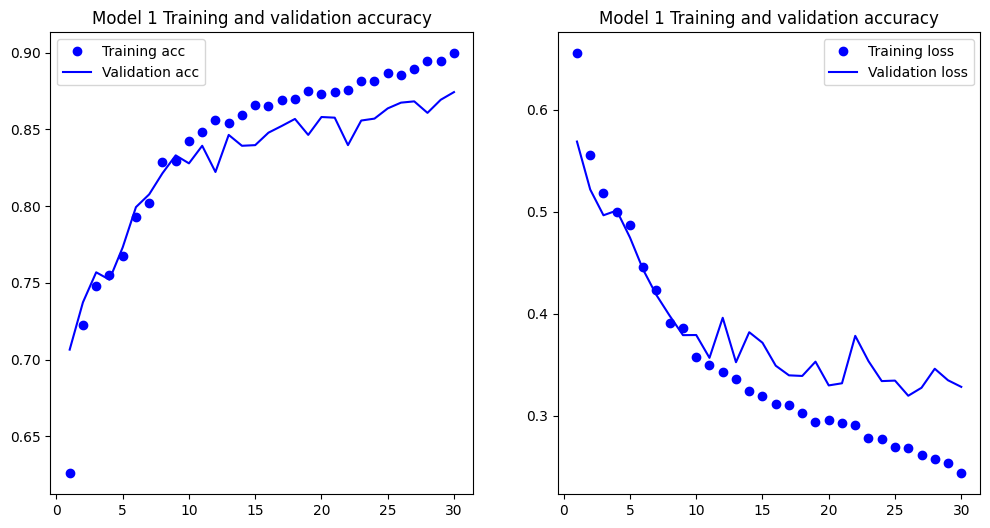

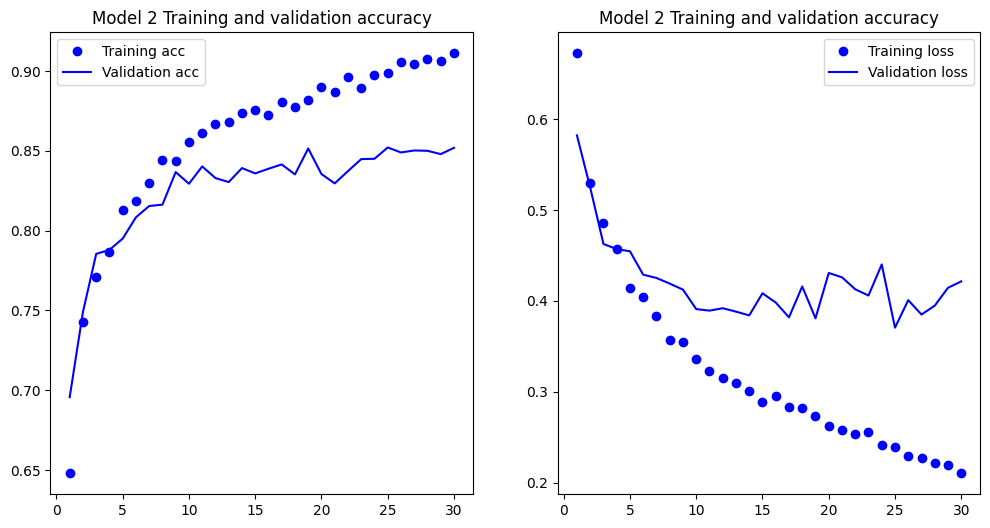

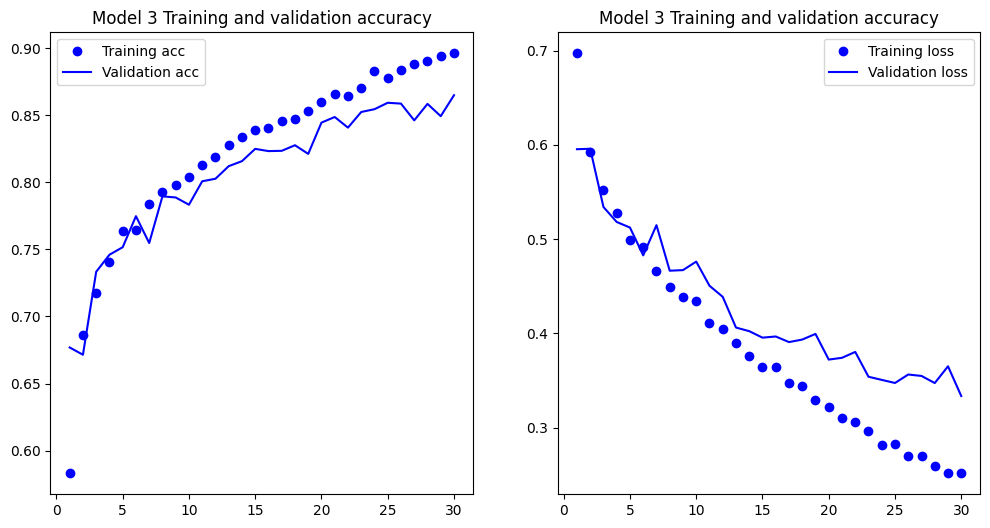

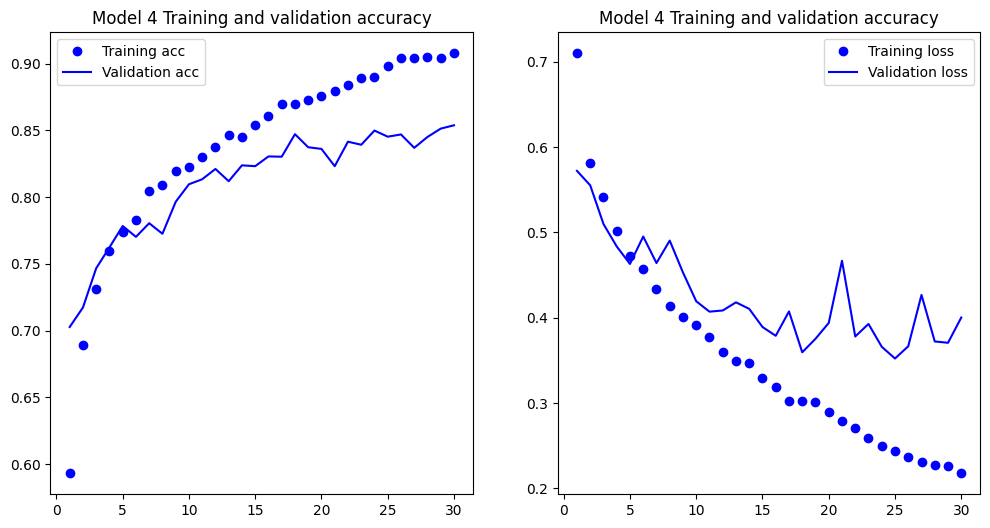

In [14]:
for i, hist in enumerate(history):
    acc = hist.history['acc'] 
    val_acc = hist.history['val_acc'] 
    loss = hist.history['loss'] 
    val_loss = hist.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training acc') 
    plt.plot(epochs, val_acc, 'b', label='Validation acc') 
    plt.title("Model %d Training and validation accuracy" %(i+1))
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss') 
    plt.plot(epochs, val_loss, 'b', label='Validation loss') 
    plt.title("Model %d Training and validation accuracy" %(i+1))
    plt.legend()

    plt.show()

In [15]:
test_generator = datagen.flow_from_directory('cifake/test',
                                                  target_size=(32, 32),
                                                  batch_size=32,
                                                  class_mode='categorical')

for i, model in enumerate(models):
    print("Model %d evaluation" %(i+1))
    test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
    print('Test accuracy:', test_acc)
    print('Test loss:', test_loss)

Found 4998 images belonging to 2 classes.
Model 1 evaluation
157/157 [==============================] - 2s 13ms/step - loss: 0.3003 - acc: 0.8846
Test accuracy: 0.884553849697113
Test loss: 0.30031442642211914
Model 2 evaluation
157/157 [==============================] - 4s 24ms/step - loss: 0.3776 - acc: 0.8569
Test accuracy: 0.8569427728652954
Test loss: 0.3775522708892822
Model 3 evaluation
157/157 [==============================] - 2s 10ms/step - loss: 0.3451 - acc: 0.8607
Test accuracy: 0.860744297504425
Test loss: 0.3450784981250763
Model 4 evaluation
157/157 [==============================] - 2s 10ms/step - loss: 0.3821 - acc: 0.8577
Test accuracy: 0.8577430844306946
Test loss: 0.38211551308631897


In [ ]:
# param_grid = [{'patch_size': 4, 'embed_dim': 128, 'num_heads': 4, 'sequence_length': 64},
#               {'patch_size': 4, 'embed_dim': 128, 'num_heads': 6, 'sequence_length': 64},
#               {'patch_size': 4, 'embed_dim': 256, 'num_heads': 4, 'sequence_length': 64},
#               {'patch_size': 4, 'embed_dim': 256, 'num_heads': 6, 'sequence_length': 64},
#               {'patch_size': 8, 'embed_dim': 128, 'num_heads': 4, 'sequence_length': 16},
#               {'patch_size': 8, 'embed_dim': 128, 'num_heads': 6, 'sequence_length': 16},
#               {'patch_size': 8, 'embed_dim': 256, 'num_heads': 4, 'sequence_length': 16},
#               {'patch_size': 8, 'embed_dim': 256, 'num_heads': 6, 'sequence_length': 16}]
param_grid = [{'patch_size': 2, 'embed_dim': 64, 'num_heads': 8, 'sequence_length': 256},
              {'patch_size': 2, 'embed_dim': 128, 'num_heads': 8, 'sequence_length': 256},
              {'patch_size': 4, 'embed_dim': 64, 'num_heads': 8, 'sequence_length': 64},
              {'patch_size': 4, 'embed_dim': 128, 'num_heads': 8, 'sequence_length': 64}]
models = []
for params in param_grid:
    model = vision_transformer(image_size=32, **params)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['acc'])
    models.append(model)

In [ ]:
history = []
for i, model in enumerate(models):
    print("Training model %d" %(i+1))
    hist = model.fit(train_generator,
                     steps_per_epoch=300,
                     epochs=30,
                     validation_data=validation_generator,
                     validation_steps=150)
    history.append(hist)